# Segmentation des clients du site E-Commerce Olist - Notebook Stabilité

### Stabilité des segmentations
Pour analyser la stabilité des segments au cours du temps, nous allons simplement réitéré les étapes précédentes sur des périodes décalés dans l'année de 30 jours, 60 jours et 90 jours. Il s'agira ensuite de déterminer la stabilité par l'indice de Rand.

#### 1. Calcul pour les 3 périodes 

In [1]:
# Standards Librairies import
%matplotlib inline
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

# Preprocessing and pipeline librairies
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

#Modelling and model evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes

In [2]:
df = pd.read_csv("olist-customers-segmentation.csv",
                   index_col=0)
df=df.drop(columns=['index'])
df=df.rename(columns={"": "purchase_time"})
df.head()

,customer_unique_id,nb_orders,distance_seller_customer,mean_product_volume_cm3,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_purchase_timestamp,dernier_achat,...,home_furniture,other,sport,technology,toys_baby,total_items,order_mean_delay,freight_ratio,mean_price_order,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,1,110.568636,7616.0,8.0,5.0,6.0,5,2018-05-10 10:56:27,2018-05-10 10:56:27,...,1.0,0.0,0.0,0.0,0.0,1.0,111.0,0.08,141.90,São Paulo
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,22.168333,5148.0,1.0,4.0,3.0,5,2018-05-07 11:11:27,2018-05-07 11:11:27,...,0.0,0.0,0.0,0.0,0.0,1.0,114.0,0.23,27.19,São Paulo
2,0000f46a3911fa3c0805444483337064,1,516.938836,43750.0,8.0,3.0,26.0,3,2017-03-10 21:05:03,2017-03-10 21:05:03,...,0.0,1.0,0.0,0.0,0.0,1.0,537.0,0.17,86.22,Santa Catarina
3,0000f6ccb0745a6a4b88665a16c9f078,1,2481.287188,1045.0,4.0,4.0,20.0,10,2017-10-12 20:29:41,2017-10-12 20:29:41,...,0.0,0.0,0.0,1.0,0.0,1.0,321.0,0.29,43.62,Pará
4,0004aac84e0df4da2b147fca70cf8255,1,154.507887,528.0,6.0,5.0,13.0,11,2017-11-14 19:45:42,2017-11-14 19:45:42,...,0.0,0.0,0.0,1.0,0.0,1.0,288.0,0.08,196.89,São Paulo


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114740 entries, 0 to 114739
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_unique_id            114740 non-null  object 
 1   nb_orders                     114740 non-null  int64  
 2   distance_seller_customer      114740 non-null  float64
 3   mean_product_volume_cm3       114740 non-null  float64
 4   mean_payment_installments     114740 non-null  float64
 5   mean_review_score             114740 non-null  float64
 6   mean_delivery_days            114740 non-null  float64
 7   favorite_sale_month           114740 non-null  int64  
 8   order_purchase_timestamp      114740 non-null  object 
 9   dernier_achat                 114740 non-null  object 
 10  payment_type                  114740 non-null  object 
 11  books_cds_media               114740 non-null  float64
 12  fashion_clothing_accessories  114740 non-nul

In [4]:
data=df.copy()

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée.

In [5]:
orders = pd.read_csv("olist_orders_dataset.csv")

orders2=orders.copy()
orders2 = orders2.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders2 = pd.to_datetime(orders2)
time_delta = int((orders2.max() - orders2.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
# On s'interesse uniquement à l''heure, le jour, et le mois de l'achat
orders=orders.rename(columns={"order_purchase_timestamp": "purchase_time"})
orders["purchase_time"] = orders["purchase_time"].astype('datetime64[ns]')

orders.head()

,order_id,customer_id,order_status,purchase_time,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
# On s'intèresse à une période d'une année entière, soit 365 jours
period = 365

from datetime import timedelta
# Jour actuel : date de la dernière commande
today = orders["purchase_time"].max() + timedelta(days=1)
today

Timestamp('2018-10-18 17:30:18')

Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import pi
from sklearn.cluster import KMeans , AgglomerativeClustering, DBSCAN

from sklearn.metrics.cluster import adjusted_rand_score

from datetime import datetime
import matplotlib.dates as mdates

In [10]:
#chargement de la table
df_clients = pd.read_csv("Olistdata.csv")
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115038 entries, 0 to 115037
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115038 non-null  object 
 1   order_item_id                  115038 non-null  int64  
 2   product_id                     115038 non-null  object 
 3   seller_id                      115038 non-null  object 
 4   price                          115038 non-null  float64
 5   freight_value                  115038 non-null  float64
 6   customer_id                    115038 non-null  object 
 7   order_status                   115038 non-null  object 
 8   order_purchase_timestamp       115038 non-null  object 
 9   order_delivered_customer_date  115038 non-null  object 
 10  delivery_duration              115038 non-null  object 
 11  delivery_hours                 115038 non-null  float64
 12  seller_state                  

In [11]:
# products volume = height*lenght*width
df_clients["product_volume_cm3"] = df_clients["product_length_cm"] \
                               * df_clients["product_height_cm"] \
                               * df_clients["product_width_cm"]

In [12]:
# Conversion en type datetime
var_to_datetime=['order_purchase_timestamp',
    "order_delivered_customer_date"]
for var in var_to_datetime:
    df_clients[var] = pd.to_datetime(df_clients[var], format='%Y-%m-%d %H:%M:%S')

In [13]:
# Période de commande
order_min = df_clients['order_purchase_timestamp'].min().strftime('%d/%m/%Y %Hh%m')
order_max = df_clients['order_purchase_timestamp'].max().strftime('%d/%m/%Y %Hh%m')
print(f'Période d\'achat : du {order_min} au {order_max}')

Période d'achat : du 15/09/2016 12h09 au 29/08/2018 15h08


In [14]:
import numpy as np
df_clients['product_categories'] = np.where((df_clients['product_category'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((df_clients['product_category'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((df_clients['product_category'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((df_clients['product_category'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((df_clients['product_category'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                           np.where((df_clients['product_category'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                           np.where((df_clients['product_category'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                                                                          'home_furniture',
                           np.where((df_clients['product_category'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((df_clients['product_category'].str.contains("sport")==True),
                                     'sport',
                                    'other')))))))))

In [15]:
#La periode de commande en mois 
orders_months = round((df_clients['order_purchase_timestamp'].max() - df_clients['order_purchase_timestamp'].min())/ np.timedelta64(1,'M'))

print("La période d'achat est de",orders_months,"mois")

La période d'achat est de 23 mois


In [16]:
# drop product_category_name column
df_clients.drop("product_category", axis=1, inplace=True)

Il n'y a pas nécessité des catégories de produits donc, nous pouvons supprimer la colonne des catégories de produits. 

In [17]:
categories_col = ['product_categories']

df_clients= df_clients.drop(categories_col, axis=1)

In [18]:
df_clients

,order_id,order_item_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,...,review_score,customer_city,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,...,5.0,campos dos goytacazes,58.0,598.0,4.0,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,...,4.0,santa fe do sul,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,...,5.0,para de minas,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,...,4.0,atibaia,42.0,480.0,1.0,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,...,5.0,varzea paulista,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115033,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-05-10 22:56:40,...,5.0,sao luis,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,53400.0
115034,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-23 20:31:55,...,5.0,curitiba,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,44460.0
115035,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-28 12:22:22,...,5.0,sao paulo,43.0,869.0,1.0,967.0,21.0,24.0,19.0,9576.0
115036,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-16 21:59:40,...,5.0,vinhedo,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,8000.0


In [19]:
wiki_url = "https://en.wikipedia.org/wiki/Federative_units_of_Brazil"
states_table = pd.read_html(wiki_url)[3].set_index("Code")
states_table.head(6)

,Flag and name,Capital,Largest city,Area(km2)[20],Population(February 2023)[21],"Density (perkm2, 2022)","GDP (R$millions, 2022)[22]",HDI(2022)[23]
Code,,,,,,,,
AC,Acre,Rio Branco,Rio Branco,164123,916000,6.34,21000,0.719
AL,Alagoas,Maceió,Maceió,27779,3383000,125.52,73000,0.683
AP,Amapá,Macapá,Macapá,142829,873000,2.63,9000,0.740
AM,Amazonas,Manaus,Manaus,1559159,4226000,2.58,103000,0.733
BA,Bahia,Salvador,Salvador,564733,15063000,30.52,257000,0.714
CE,Ceará,Fortaleza,Fortaleza,148921,8934000,60.33,157000,0.735


In [20]:
df_clients = pd.merge(df_clients.reset_index(), states_table[["Flag and name"]],
                how="left",
                left_on="customer_state",
                right_on="Code")

df_clients.drop("customer_state", axis=1, inplace=True)

df_clients = df_clients.rename(columns={"Flag and name": "customer_state"})
df_clients.head()

,index,order_id,order_item_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,customer_city,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,customer_state
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,campos dos goytacazes,58.0,598.0,4.0,650.0,28.0,9.0,14.0,3528.0,Rio de Janeiro
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,santa fe do sul,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,60000.0,São Paulo
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,para de minas,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,14157.0,Minas Gerais
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,atibaia,42.0,480.0,1.0,200.0,16.0,10.0,15.0,2400.0,São Paulo
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,varzea paulista,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,42000.0,São Paulo


In [21]:
#df_clients = df_clients.rename(columns={"nb_orders": "Frequency", "mean_price_order": "Monetary","order_mean_delay":"Recency"})
#create duplicate points column
df_clients['order_id_duplicate'] = df_clients.loc[:, 'order_id']

In [22]:
from pandas.tseries.offsets import DateOffset
'''Fonction qui sélectionne les commandes en fonction de la période 
définie.
On recalculera les différentes variables utilisées dans la simulation.
'''
def selection_period(df, initial, period):
    #Fonction qui génère un fichier en fonction de la date 
      
    # selection en fonction de la date de commande
    #order Month
    start=df['order_purchase_timestamp'].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    df=df[(df['order_purchase_timestamp']>=start)
                              & (df['order_purchase_timestamp']<stop)]
    
    # List of orders on period
    period_orders = df.order_id.unique()
    
    # Calculate other features on period
    df = df[df['order_id'].isin(period_orders)]
    #creation du dataset clients 
    
    #Calcul du nombre de delivery days
    df["delivery_delta_days"] = (df.order_delivered_customer_date
                               - df.order_purchase_timestamp)\
                              .dt.round('1d').dt.days

    #df= df.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    
    # Calcul du nombre de jours écoulés entre la première et dernière commande
    recurencies = df.groupby("customer_unique_id")\
                .agg({"order_purchase_timestamp": ["min","max"]})
    recurencies.columns = recurencies.columns.droplevel(0)

    # Max date in dataset
    max_date = df["order_purchase_timestamp"].max()

    # Delay from the last order
    recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0] 
                                    else (max_date - y[0]).round('1d').days 
                                    for x,y in recurencies.iterrows()]
    recurencies.drop(["min", "max"], axis=1, inplace=True)
    
    
    # Mapping du dernier chat 
    df_dernier_achat = df.groupby('customer_unique_id')[
    'order_purchase_timestamp'].max()
    df['dernier_achat'] = df['customer_unique_id'] \
    .map(df_dernier_achat)
    
    
    # Group by customers
    dico_aggr = {
              "order_id": lambda x: x.mode()[0],
              'order_id_duplicate': 'nunique',
              "price": 'sum',
              "freight_value": "sum",
               "distance_seller_customer":"mean",
               "product_weight_g":"mean",
               "product_volume_cm3":"mean",
               "nb_payment_sequential": "mean", 
                "sum_payment_installments": "mean", 
                "review_score": "mean",
                "delivery_delta_days": "mean",
                "sale_month": lambda x:x.value_counts().index[0],
                'order_purchase_timestamp': lambda x: x.mode()[0],
                'dernier_achat':lambda x: x.mode()[0]
             }
    
    
    df_new=df.groupby(['customer_unique_id']).agg(dico_aggr)
    
    # Add states to customers and sellers 
    df_2=df[["customer_unique_id","seller_state","customer_state","payment_type"]]
    
    df_new = pd.merge(df_new, df_2,
                how="left",
                on="customer_unique_id")
    
    
    # Rename columns et Frequency
    df_new = df_new.rename(columns={"order_id_duplicate": "Frequency",
                            "price": "total_spend",
                            "freight_value": "total_freight",
                            "product_weight_g":"mean_products_weight",
                            "product_volume_cm3":"mean_product_volume_cm3",
                            "nb_payment_sequential": "mean_payment_sequential",
                            "sum_payment_installments": "mean_payment_installments",
                            "review_score": "mean_review_score",
                            "delivery_delta_days": "mean_delivery_days",
                            "sale_month": "favorite_sale_month"
                        
                                 })
    #Merge with recurencies
    df_new = pd.merge(df_new, recurencies,
                how="left",
                on="customer_unique_id")
    # Calcul Recency
    df_new["Recency"] = df_new["order_total_delay"] / df_new["Frequency"]
    
    df_new.drop("order_total_delay", axis=1, inplace=True)
    
    df_new["total_spend"] = (df_new["total_spend"] + df_new["total_freight"])
    df_new["freight_ratio"] = round(df_new["total_freight"] / (df_new["total_spend"]),2)
    
    #Calcul Monetary
    df_new["Monetary"] = round(df_new["total_spend"] / df_new["Frequency"],2)
    df_new.drop("total_freight", axis=1, inplace=True)
    
    # Find features to fill and fillna with mode
    features_to_fill = df_new.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

    for f in features_to_fill:
        df_new[f] = df_new[f].fillna(df_new[f].mode()[0])
        
    #Drop duplicates
    df_new.drop_duplicates()
    
    #Drop other columns due to correlations
    
    df_new=df_new.drop(columns=['total_spend', 'mean_products_weight','mean_payment_sequential','seller_state'])
    
    return df_new

In [26]:
def preprocessing(df):
    #set index to customer id
    df.set_index('customer_unique_id')
    
    #Select categorical features
    categorical_features = list(df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
    
    df_new=df.drop(columns=['customer_unique_id','order_id','order_purchase_timestamp','dernier_achat'])
    
    # Encodage binaire de l'état des acheteurs, Sao Paulo ou Non
    df_new.loc[df_new["customer_state"] != "SP", "customer_state"] = 0
    df_new.loc[df_new["customer_state"] == "SP", "customer_state"] = 1

    df_new["customer_state"] = df_new["customer_state"].astype('float64')

    # Encodage binaire du type de payment, Credit card ou Non
    df_new.loc[df_new["payment_type"] != "credit_card", "payment_type"] = 0.0
    df_new.loc[df_new["payment_type"] == "credit_card", "payment_type"] = 1.0


    df_new["payment_type"] = df_new["payment_type"].astype('float64')

    return df_new

In [25]:
#transformation en log pour skew>1
def transformation_log(df, var):
    for i in var:
        if round(df[i].skew(), 2) > 1:
            df[i] = np.log1p(df[i])
    return df

In [29]:
def scaler(df):
    cols=df.columns
    scaler=MinMaxScaler()
    df=scaler.fit_transform(df)
    df=pd.DataFrame(df,columns=[cols])
    return df

In [27]:
#fonction de calcul de l'ARI
def fonction_maintenance (df, k):
    
    df_initial=selection_period(df,initial=True, period=1)
    df_initial=preprocessing(df_initial)
    #au temps T0
    var=df_initial.columns.to_list()
    #var.remove('rfm_recence')
    df_initial=transformation_log(df_initial, var)
    X_0=scaler(df_initial).values
    
    model_initial=KMeans(n_clusters=k)
    model_initial.fit(X_0)
    model_initial_labels=model_initial.labels_
    
    
    #simulaition Ti, Ti+1
    ari_score = []
    for i in range(1,int((orders_months-12))):
        df_heredite=selection_period(df,initial=False, period=i)
        df_heredite=preprocessing(df_heredite)
        #au temps Ti
        var=df_heredite.columns.to_list()
        df_heredite=transformation_log(df_heredite, var)
        
        X=scaler(df_heredite).values
        model_h=KMeans(n_clusters=k)
        model_h.fit(X)
        model_h_labels=model_h.labels_
       
        ari_i = adjusted_rand_score(model_initial.predict(X),model_h_labels)
        ari_score.append([i,ari_i])
        
    return ari_score

In [30]:
ari_score=fonction_maintenance (df_clients, 5)

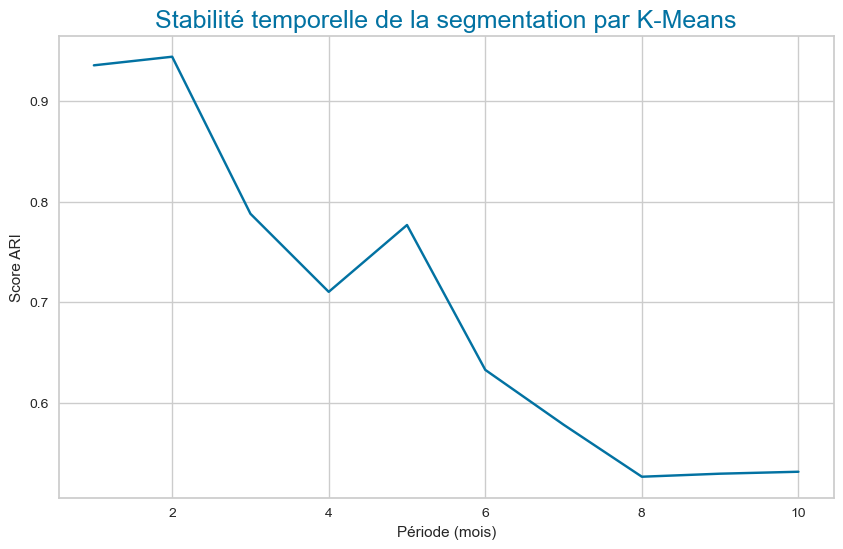

In [31]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

# Travail avec Clustering RFM et quelues paramètres

In [33]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115038 entries, 0 to 115037
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   index                          115038 non-null  int64         
 1   order_id                       115038 non-null  object        
 2   order_item_id                  115038 non-null  int64         
 3   product_id                     115038 non-null  object        
 4   seller_id                      115038 non-null  object        
 5   price                          115038 non-null  float64       
 6   freight_value                  115038 non-null  float64       
 7   customer_id                    115038 non-null  object        
 8   order_status                   115038 non-null  object        
 9   order_purchase_timestamp       115038 non-null  datetime64[ns]
 10  order_delivered_customer_date  115038 non-null  datetime64[ns]
 11  

In [44]:
'''Fonction qui sélectionne les commandes en fonction de la période 
définie.
On recalculera les différentes variables utilisées dans la simulation.
'''
def selection_period2(df, initial, period):
    #Fonction qui génère un fichier en fonction de la date 
      
    # selection en fonction de la date de commande
    #order Month
    start=df['order_purchase_timestamp'].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    df=df[(df['order_purchase_timestamp']>=start)
                              & (df['order_purchase_timestamp']<stop)]
    
    # List of orders on period
    period_orders = df.order_id.unique()
    
    # Calculate other features on period
    df = df[df['order_id'].isin(period_orders)]
    #creation du dataset clients 
    
    #Calcul du nombre de delivery days
    df["delivery_delta_days"] = (df.order_delivered_customer_date
                               - df.order_purchase_timestamp)\
                              .dt.round('1d').dt.days

    #df= df.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    
    # Calcul du nombre de jours écoulés entre la première et dernière commande
    recurencies = df.groupby("customer_unique_id")\
                .agg({"order_purchase_timestamp": ["min","max"]})
    recurencies.columns = recurencies.columns.droplevel(0)

    # Max date in dataset
    max_date = df["order_purchase_timestamp"].max()

    # Delay from the last order
    recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0] 
                                    else (max_date - y[0]).round('1d').days 
                                    for x,y in recurencies.iterrows()]
    recurencies.drop(["min", "max"], axis=1, inplace=True)
    
    
    # Mapping du dernier chat 
    df_dernier_achat = df.groupby('customer_unique_id')[
    'order_purchase_timestamp'].max()
    df['dernier_achat'] = df['customer_unique_id'] \
    .map(df_dernier_achat)
    
    
    # Group by customers
    dico_aggr = {
              "order_id": lambda x: x.mode()[0],
              'order_id_duplicate': 'nunique',
              "price": 'sum',
              "freight_value": "sum",
               "distance_seller_customer":"mean",
               "product_weight_g":"mean",
               "product_volume_cm3":"mean",
               "nb_payment_sequential": "mean", 
                "sum_payment_installments": "mean", 
                "review_score": "mean",
                "delivery_delta_days": "mean",
                "sale_month": lambda x:x.value_counts().index[0],
                'order_purchase_timestamp': lambda x: x.mode()[0],
                'dernier_achat':lambda x: x.mode()[0]
             }
    
    
    df_new=df.groupby(['customer_unique_id']).agg(dico_aggr)
    
    # Add states to customers and sellers 
    df_2=df[["customer_unique_id","seller_state","customer_state","payment_type"]]
    
    df_new = pd.merge(df_new, df_2,
                how="left",
                on="customer_unique_id")
    
    
    # Rename columns et Frequency
    df_new = df_new.rename(columns={"order_id_duplicate": "Frequency",
                            "price": "total_spend",
                            "freight_value": "total_freight",
                            "product_weight_g":"mean_products_weight",
                            "product_volume_cm3":"mean_product_volume_cm3",
                            "nb_payment_sequential": "mean_payment_sequential",
                            "sum_payment_installments": "mean_payment_installments",
                            "review_score": "mean_review_score",
                            "delivery_delta_days": "mean_delivery_days",
                            "sale_month": "favorite_sale_month"
                        
                                 })
    #Merge with recurencies
    df_new = pd.merge(df_new, recurencies,
                how="left",
                on="customer_unique_id")
    # Calcul Recency
    df_new["Recency"] = df_new["order_total_delay"] / df_new["Frequency"]
    
    df_new.drop("order_total_delay", axis=1, inplace=True)
    
    df_new["total_spend"] = (df_new["total_spend"] + df_new["total_freight"])
    df_new["freight_ratio"] = round(df_new["total_freight"] / (df_new["total_spend"]),2)
    
    #Calcul Monetary
    df_new["Monetary"] = round(df_new["total_spend"] / df_new["Frequency"],2)
    df_new.drop("total_freight", axis=1, inplace=True)
    
    #Select Features
    new_feats=['customer_unique_id','order_id','order_purchase_timestamp','dernier_achat','Recency', 'Frequency', 'Monetary','mean_review_score','total_spend','mean_payment_installments']
    df_new=df_new[new_feats]
   
    
    
    # Find features to fill and fillna with mode
    features_to_fill = df_new.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

    for f in features_to_fill:
        df_new[f] = df_new[f].fillna(df_new[f].mode()[0])
        
    #Drop duplicates
    df_new.drop_duplicates()
    
    #Drop other columns due to correlations
    
    df_new=df_new.drop(columns=['total_spend'])
    
    return df_new

In [50]:
def preprocessing2(df):
    #set index to customer id
    df.set_index('customer_unique_id')
    
    #Select categorical features
    categorical_features = list(df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
    
    df_new=df.drop(columns=['customer_unique_id','order_id','order_purchase_timestamp','dernier_achat'])

    return df_new

In [48]:
#fonction de calcul de l'ARI
def fonction_maintenance2 (df, k):
    
    df_initial=selection_period2(df,initial=True, period=1)
    df_initial=preprocessing2(df_initial)
    #au temps T0
    var=df_initial.columns.to_list()
    #var.remove('rfm_recence')
    df_initial=transformation_log(df_initial, var)
    X_0=scaler(df_initial).values
    
    model_initial=KMeans(n_clusters=k)
    model_initial.fit(X_0)
    model_initial_labels=model_initial.labels_
    
    
    #simulaition Ti, Ti+1
    ari_score = []
    for i in range(1,int((orders_months-12))):
        df_heredite=selection_period2(df,initial=False, period=i)
        df_heredite=preprocessing2(df_heredite)
        #au temps Ti
        var=df_heredite.columns.to_list()
        df_heredite=transformation_log(df_heredite, var)
        
        X=scaler(df_heredite).values
        model_h=KMeans(n_clusters=k)
        model_h.fit(X)
        model_h_labels=model_h.labels_
       
        ari_i = adjusted_rand_score(model_initial.predict(X),model_h_labels)
        ari_score.append([i,ari_i])
        
    return ari_score

In [51]:
ari_score=fonction_maintenance2 (df_clients, 5)

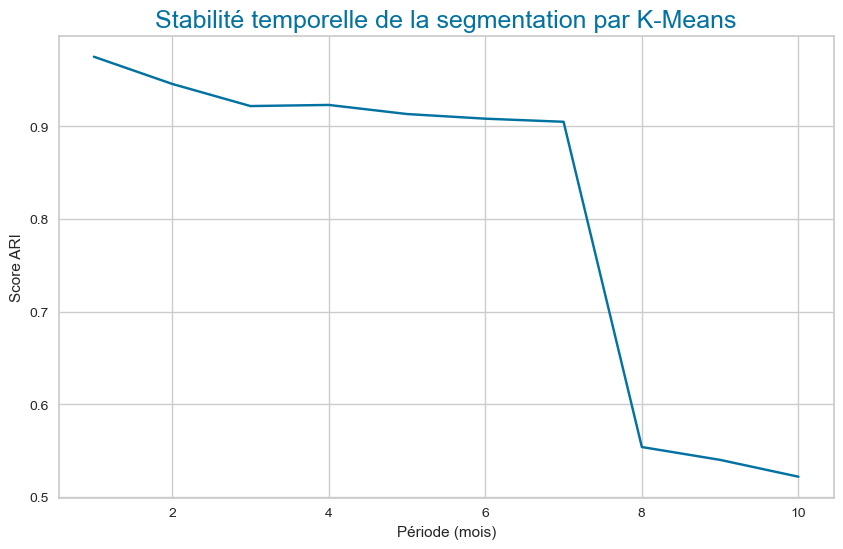

In [52]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Il faut effectuer un contrat de maintenance tou les 8 mois. 